In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Introduction
In this Notebook we show how to build a multiclass classifier, by:
- applying simple pre-processing steps
- trying different baseline algorithms
- optimizing the hyperparameters of XGBoost

In the pre-processing steps, we convert the non numerical features using the LabelEncoding for most of the columns, i.e. for the columns that have only two possible values or more than two sortable values.
The only column that has not these characteristics is the MTRANS, where we apply the one-hot encoding.

Then we do some data exploration, analzying the correlation between numerical features and labels, the distribution of train and test data, the distribution of labels, etc...

Then we train 4 different baseline classifier: RandomForest, GradientBoosting, LightGBM and XGBoost.
XGBoost shows the best performance, so we decide to optimize its hyperparameters by using the framework Optuna.

Finally we perform the predictios in two ways:
- using all the training data
- using 5-fold stratified splitting and computing the average predicted probabilities out of 5

# 1. Import data
We import the data and we create two subsets:
- one with numerical data
- one with categorical data

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col=0)

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
#add data[BMI]
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

features = df.drop('NObeyesdad', axis=1)
labels = pd.DataFrame(df['NObeyesdad'])

features

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,36.587084
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,17.099278
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,31.889841


# 2. Data exploration and pre-processing 

### Numerical DataFrame

In [4]:
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
id,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151
...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,36.587084
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,17.099278
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,31.889841


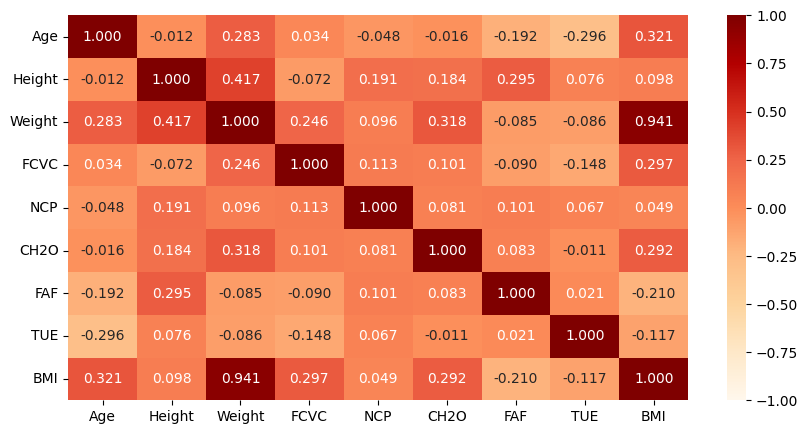

In [5]:
corr_numerical = df_numerical.corr()

import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(corr_numerical, annot=True, cmap="OrRd", fmt='.3f', cbar=True, vmin=-1, vmax=1)
plt.show()

### Categorical DataFrame

In [6]:
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())

Gender
Female    10422
Male      10336
Name: count, dtype: int64
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
FAVC
yes    18982
no      1776
Name: count, dtype: int64
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SCC
no     20071
yes      687
Name: count, dtype: int64
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


In [7]:
df_encoded = df_categorical.copy(deep=True)

# label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})


df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
df_encoded.drop('MTRANS', axis=1, inplace=True)


# concatenate
# one feature of df_encoded is redundant; we can remove it
df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, 0:-1]], axis=1)

df_encoded

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation
id,,,,,,,,,,,
0,0,1,1,1,0,0,1,0,0,0,1
1,1,1,1,2,0,0,0,1,0,0,0
2,1,1,1,1,0,0,0,0,0,0,1
3,1,1,1,1,0,0,1,0,0,0,1
4,0,1,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
20753,0,1,1,1,0,0,1,0,0,0,1
20754,0,0,1,2,0,0,1,0,0,0,1
20755,0,1,1,1,0,0,0,0,0,0,1


### Concatenate all features together

In [8]:
df_all_features = pd.concat([df_numerical, df_encoded], axis=1)

df_all_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation
id,,,,,,,,,,,,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565,0,1,1,1,0,0,1,0,0,0,1
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091,1,1,1,2,0,0,0,1,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706,1,1,1,1,0,0,0,0,0,0,1
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798,1,1,1,1,0,0,1,0,0,0,1
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151,0,1,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,36.587084,0,1,1,1,0,0,1,0,0,0,1
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,17.099278,0,0,1,2,0,0,1,0,0,0,1
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,31.889841,0,1,1,1,0,0,0,0,0,0,1


### Define a pre-processing pipeline

Let us summarize all the previous steps into a function, called `apply_preprocessing`

In [9]:
def apply_preprocessing(data):
    features = data.copy(deep=True)
    
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
    
    
    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})

    
    # one-hot encoding
    df_onehot = pd.get_dummies(df_categorical['MTRANS']).astype(int)
    df_encoded.drop('MTRANS', axis=1, inplace=True)

    # concatenate
    # one feature of df_encoded is redundant; we can remove it
    df_encoded = pd.concat([df_encoded, df_onehot.iloc[:, 0:-1]], axis=1)
    
    df_all_features = pd.concat([df_numerical, df_encoded], axis=1)
    
    return df_all_features

### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.

The test dataset will be used to make predictions and submit them to the competition.

In [10]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col=0)

#add data[BMI]
df_test['BMI'] = df_test['Weight'] / (df_test['Height'] ** 2)

df_test = apply_preprocessing(df_test)

df_test 
print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)

assert all(df_test.columns ==  df_all_features.columns), "Columns in train and test dataset must be the same"

Train columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation'],
      dtype='object')
Test columns Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'Automobile', 'Bike', 'Motorbike',
       'Public_Transportation'],
      dtype='object')


/tmp/ipykernel_18/2909093292.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


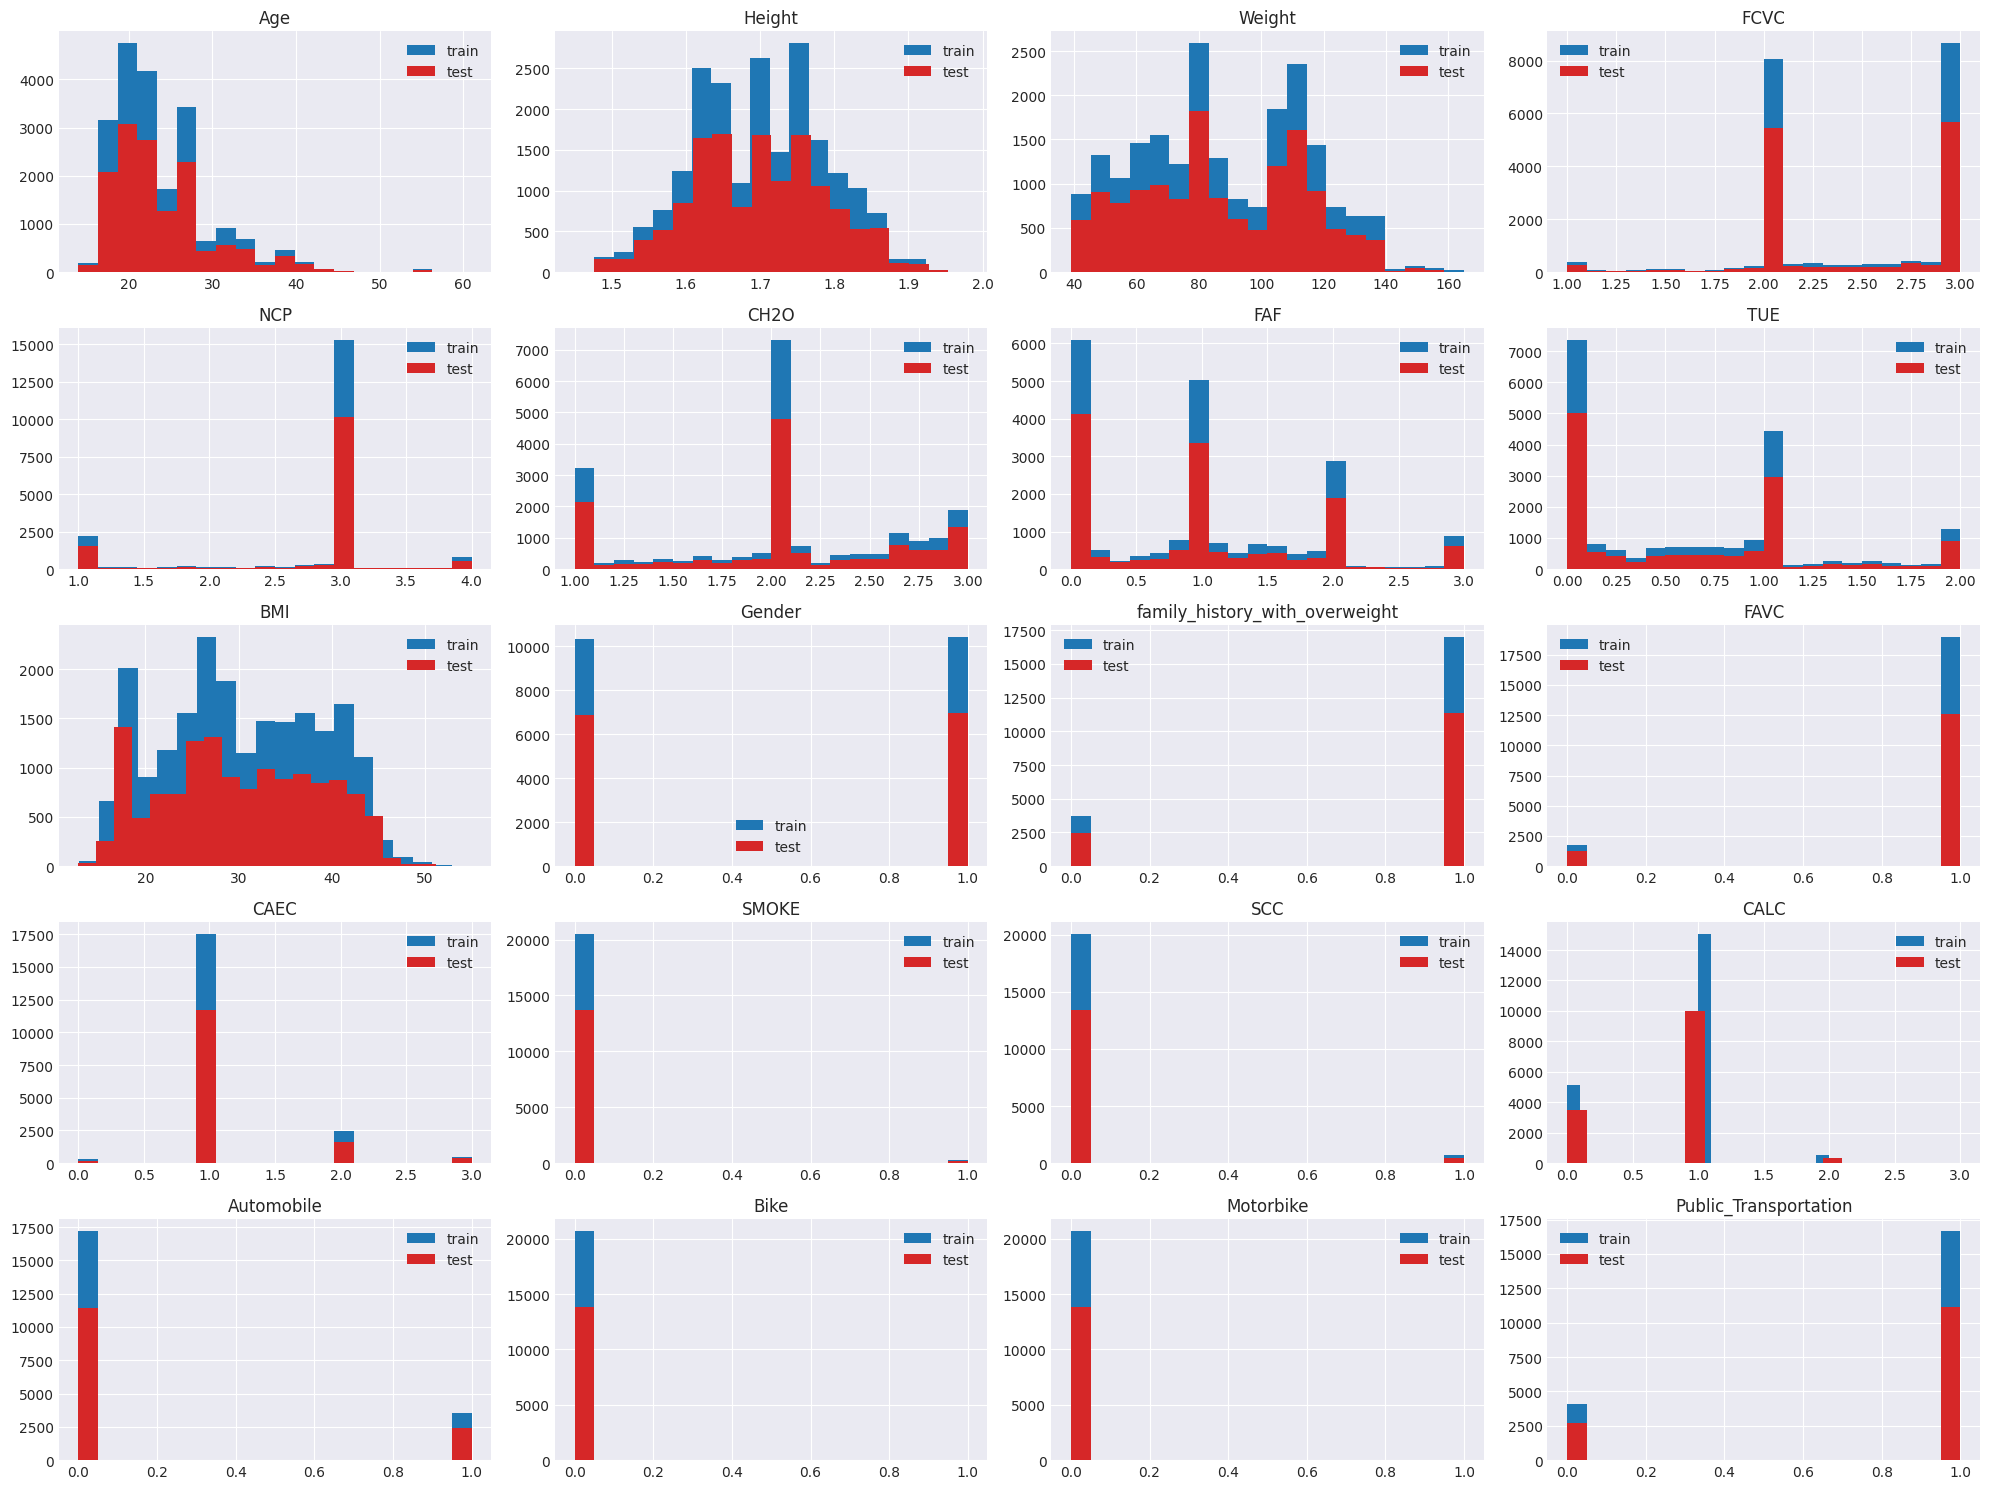

In [11]:
plt.style.use('seaborn-dark')

plt.figure(figsize=(20, 15))

for i in range(df_all_features.shape[1]):
    plt.subplot(5, 4, i+1)
    plt.hist(df_all_features.iloc[:, i], bins=20, label='train')
    plt.hist(df_test.iloc[:, i], bins=20,
             alpha=1, label='test', color='C3')
    plt.title(df_all_features.columns[i])
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

### Labels

In [12]:
labels['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [13]:
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded

,NObeyesdad
id,
0,3
1,1
2,0
3,6
4,3
...,...
20753,5
20754,0
20755,5


In [14]:
labels_encoded.value_counts()

NObeyesdad
6             4046
5             3248
1             3082
4             2910
0             2523
3             2522
2             2427
Name: count, dtype: int64

/tmp/ipykernel_18/341045427.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


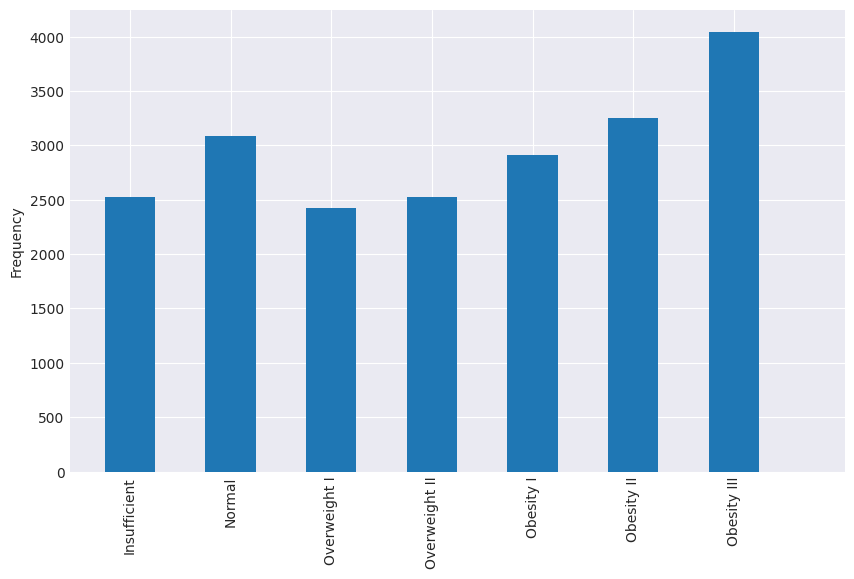

In [15]:
plt.style.use('seaborn-dark')

plt.figure(figsize=(10, 6))
plt.hist(labels_encoded, bins=np.arange(0, 8)-0.25, width=0.5, align='mid')
plt.grid()
plt.xticks(np.arange(0, 6.1),
           ['Insufficient', 'Normal', 'Overweight I', 'Overweight II', 'Obesity I', 'Obesity II', 'Obesity III'],
           rotation=90)
plt.ylabel('Frequency')
plt.show()

# 3. Prepare data for machine learning

In [16]:
X = df_all_features
y = np.ravel(labels_encoded)

# compare train and test data
X_test = df_test
assert all(X_test.columns == X.columns), "Columns of training and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y,
                                                                test_size=0.2, 
                                                                random_state=42,
                                                                stratify=y)

Number of samples 20758
Number of featires 20


# 4. Fit the data with baseline models

In [17]:
'''
from sklearn.utils.class_weight import compute_class_weight

# calculate class weights based on the training data
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y),
                                     y=y)

class_weights = dict(zip(np.unique(y), class_weights))
class_weights
'''

"\nfrom sklearn.utils.class_weight import compute_class_weight\n\n# calculate class weights based on the training data\nclass_weights = compute_class_weight('balanced', \n                                     classes=np.unique(y),\n                                     y=y)\n\nclass_weights = dict(zip(np.unique(y), class_weights))\nclass_weights\n"

In [18]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 20
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [19]:
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)

    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
        
    print('===========================')

In [20]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

Random Forest
Train score 1.0
Test score 0.897
Overfitting detected
LightGBM
Train score 0.983
Test score 0.9
Overfitting detected
Gradient Boosting
Train score 0.921
Test score 0.898
XGBoost
Train score 0.99
Test score 0.9
Overfitting detected


# 5. Hyperparameter tuning
We fine-tune the XGBoost Classifier defined in the previous section, using the optimizer framework called `Optuna`.

In [21]:
import optuna
from sklearn.model_selection import cross_validate

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost
    params = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'gamma': gamma,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'eval_metric':'mlogloss'}
        
    clf = XGBClassifier(**params)
    

    # LightGBM
    params = {'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'max_depth': max_depth,
              'lambda_l1': reg_alpha,
              'lambda_l2': reg_lambda,
              'colsample_bytree': colsample_bytree, 
              'subsample': subsample,    
              'min_child_samples': min_child_weight,
              'class_weight': 'balanced'}
    
    clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)

    
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [22]:
# Uncomment this section if you want to do hyperparameter tuning

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-02-24 09:47:35,682] A new study created in memory with name: no-name-c397b2b3-0b17-474d-bb23-71fec9422892


Training the model with 20 features


[I 2024-02-24 09:48:48,103] Trial 0 finished with value: 0.9013394757351225 and parameters: {'max_depth': 10, 'n_estimators': 1612, 'gamma': 0.03183949148402199, 'reg_alpha': 0.4945561778025118, 'reg_lambda': 0.5563915552084351, 'min_child_weight': 6, 'subsample': 0.007534007327964276, 'colsample_bytree': 0.1665441880408799, 'learning_rate': 0.34332307068233947}. Best is trial 0 with value: 0.9013394757351225.


Training the model with 20 features


[I 2024-02-24 09:50:05,753] Trial 1 finished with value: 0.8921863431937611 and parameters: {'max_depth': 9, 'n_estimators': 1436, 'gamma': 0.7877351707708489, 'reg_alpha': 0.28130286171397634, 'reg_lambda': 0.6068760343140535, 'min_child_weight': 6, 'subsample': 0.700232575301356, 'colsample_bytree': 0.3892636025557389, 'learning_rate': 0.9408734699641826}. Best is trial 0 with value: 0.9013394757351225.


Training the model with 20 features


[I 2024-02-24 09:53:10,248] Trial 2 finished with value: 0.9048561202839439 and parameters: {'max_depth': 7, 'n_estimators': 1442, 'gamma': 0.34708160151891143, 'reg_alpha': 0.6063756287753649, 'reg_lambda': 0.09281144842950151, 'min_child_weight': 5, 'subsample': 0.46590123918411175, 'colsample_bytree': 0.6799737929141072, 'learning_rate': 0.02488853314763917}. Best is trial 2 with value: 0.9048561202839439.


Training the model with 20 features


[I 2024-02-24 09:54:24,951] Trial 3 finished with value: 0.8960399657625968 and parameters: {'max_depth': 6, 'n_estimators': 1508, 'gamma': 0.6794778440213602, 'reg_alpha': 0.9343769003194734, 'reg_lambda': 0.6184972128708922, 'min_child_weight': 6, 'subsample': 0.47237509496297925, 'colsample_bytree': 0.355585593080761, 'learning_rate': 0.8577219939904898}. Best is trial 2 with value: 0.9048561202839439.


Training the model with 20 features


[I 2024-02-24 09:56:19,192] Trial 4 finished with value: 0.9077947881723141 and parameters: {'max_depth': 9, 'n_estimators': 894, 'gamma': 0.8399655278606185, 'reg_alpha': 0.7205211689688814, 'reg_lambda': 0.59449422165266, 'min_child_weight': 1, 'subsample': 0.3782161167185849, 'colsample_bytree': 0.41539971983927415, 'learning_rate': 0.03493806408135669}. Best is trial 4 with value: 0.9077947881723141.


In [23]:
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study.head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
4,4,0.907795,2024-02-24 09:54:24.953077,2024-02-24 09:56:19.191163,0 days 00:01:54.238086,0.415400,0.839966,0.034938,9,1,894,0.720521,0.594494,0.378216,COMPLETE
2,2,0.904856,2024-02-24 09:50:05.754676,2024-02-24 09:53:10.247611,0 days 00:03:04.492935,0.679974,0.347082,0.024889,7,5,1442,0.606376,0.092811,0.465901,COMPLETE
0,0,0.901339,2024-02-24 09:47:35.685262,2024-02-24 09:48:48.103116,0 days 00:01:12.417854,0.166544,0.031839,0.343323,10,6,1612,0.494556,0.556392,0.007534,COMPLETE
3,3,0.896040,2024-02-24 09:53:10.249578,2024-02-24 09:54:24.951022,0 days 00:01:14.701444,0.355586,0.679478,0.857722,6,6,1508,0.934377,0.618497,0.472375,COMPLETE
1,1,0.892186,2024-02-24 09:48:48.105073,2024-02-24 09:50:05.752800,0 days 00:01:17.647727,0.389264,0.787735,0.940873,9,6,1436,0.281303,0.606876,0.700233,COMPLETE


In [24]:
# best_params_XGB = study.best_params

# Best parameters for XGBoost obtained after Optuna optimization

best_params_XGB ={'max_depth': 6,
                  'n_estimators': 793,
                  'gamma': 0.13219040111589608,
                  'reg_alpha': 0.8979926035174041, 
                  'reg_lambda': 0.6057946358089595, 
                  'min_child_weight': 3, 
                  'subsample': 0.9840737574073746, 
                  'colsample_bytree': 0.4381221700983686, 
                  'learning_rate': 0.6044163952699279}

# best_params_XGB = {'max_depth': 10, 
#                    'n_estimators': 1224, 
#                    'gamma': 0.8323134488556143, 
#                    'reg_alpha': 0.9211957174104992, 
#                    'reg_lambda': 0.8522905506401445, 
#                    'min_child_weight': 4, 
#                    'subsample': 0.9232723357974977, 
#                    'colsample_bytree': 0.4785000546841373, 
#                    'learning_rate': 0.06435693511798936}

# print(best_params_XGB)

Also hyperparameters for LightGBM Classifier have been optimized. In case you want to test it, please uncomment the following cell.

In [25]:
# # Best parameters for LightGBM obtained after Optuna optimization
# best_params_LGBM = study.best_params

best_params_LGBM = {'max_depth': 6, 
                    'n_estimators': 1750, 
                    'gamma': 0.8245358709544012,
                    'reg_alpha': 0.8050274884780146, 
                    'reg_lambda': 0.6103556795215724, 
                    'min_child_weight': 1, 
                    'subsample': 0.11501180422050117, 
                    'colsample_bytree': 0.40581015124472175,
                    'learning_rate': 0.40942579679657387}

# best_params_LGBM = {'max_depth': 5, 
#                     'n_estimators': 1086, 
#                     'gamma': 0.21718199012686834, 
#                     'lambda_l1': 0.9770735787707583, 
#                     'lambda_l2': 0.8576215710818857, 
#                     'min_child_samples': 4, 
#                     'subsample': 0.9343204270146038, 
#                     'colsample_bytree': 0.6782348565590313, 
#                     'learning_rate': 0.014669435683414833}

# print(best_params_LGBM)

# 6. Train the best model and export the results

In [26]:
# train the best model

clf = XGBClassifier(**best_params_XGB)

#clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)

clf.fit(X, y)


predictions = clf.predict(X_test)

In [27]:
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))

df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

df_submission['NObeyesdad'] = predictions
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission.to_csv('submission.csv', index=False)

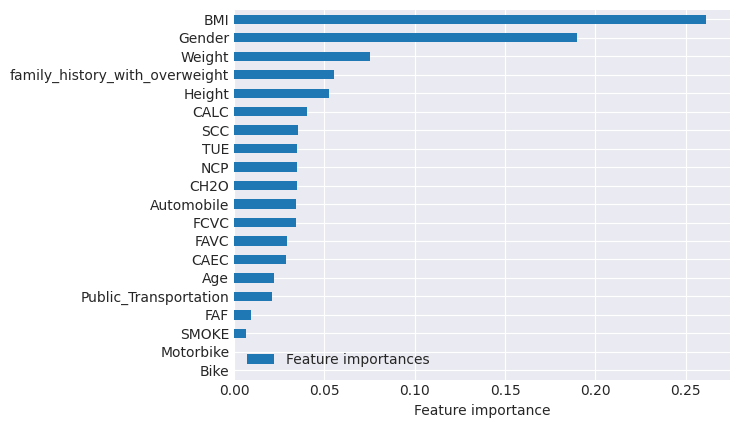

In [28]:
df_features = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['Feature importances'])
df_features = df_features.sort_values('Feature importances')

df_features.plot(kind='barh')
plt.grid()
plt.xlabel('Feature importance')
plt.show()

# 7. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost together with cross-validation.
We make 5 predictions for each sample and then we compute the average probability to assign the label.

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def train_evaluate_model(X, y, X_test):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(X)[train_index, :]
        y_train = np.array(y)[train_index]
        X_val = np.array(X)[val_index, :]
        y_val = np.array(y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        clf = XGBClassifier(**best_params_XGB)
        clf.fit(X=X_train, y=y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=10,
                verbose=50)
        
        #clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
        #clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
        
        y_pred_val = clf.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test_proba = clf.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(clf)
        
    return scores, np.array(predictions), clfs

In [30]:
scores, predictions, clfs = train_evaluate_model(X, y, X_test)

Fitting with k-fold 1 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.00645	validation_1-mlogloss:1.01773


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-mlogloss:0.13716	validation_1-mlogloss:0.26084
validation score is 0.9137764932562621
Round 1 Predictions stored successfully
Fitting with k-fold 2 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.00288	validation_1-mlogloss:1.02717


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-mlogloss:0.12829	validation_1-mlogloss:0.29185
validation score is 0.9039017341040463
Round 2 Predictions stored successfully
Fitting with k-fold 3 out of 16606
Training on 16606 samples
Evaluating on 4152 samples
[0]	validation_0-mlogloss:1.00910	validation_1-mlogloss:1.01697


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-mlogloss:0.13822	validation_1-mlogloss:0.26265
validation score is 0.9092003853564548
Round 3 Predictions stored successfully
Fitting with k-fold 4 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.00823	validation_1-mlogloss:1.02633


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-mlogloss:0.13326	validation_1-mlogloss:0.28737
validation score is 0.9017104312213924
Round 4 Predictions stored successfully
Fitting with k-fold 5 out of 16607
Training on 16607 samples
Evaluating on 4151 samples
[0]	validation_0-mlogloss:1.00698	validation_1-mlogloss:1.02809


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-mlogloss:0.12683	validation_1-mlogloss:0.27946
validation score is 0.9038785834738617
Round 5 Predictions stored successfully


In [31]:
print('Average evaluation score = ', np.mean(scores))

Average evaluation score =  0.9064935254824034


In [32]:
y_test_pred = np.mean(predictions, axis=0)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_pred

array([5, 2, 6, ..., 0, 1, 5])

In [33]:
df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

#df_submission.to_csv('submission.csv', index=False)

### Explore results of one of the model previously trained

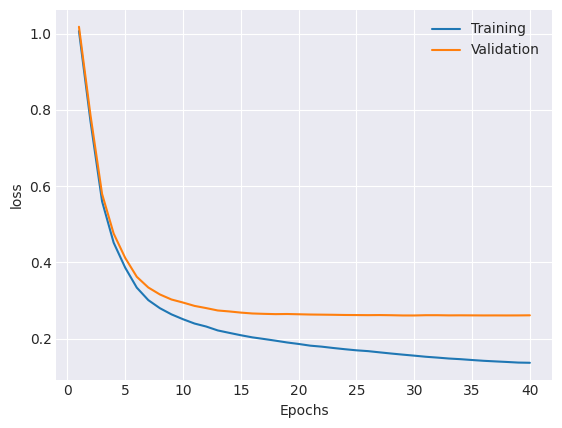

In [34]:
# this section works only for XGBoost

results = clfs[0].evals_result()

train_loss = results['validation_0']['mlogloss']
validation_loss = results['validation_1']['mlogloss']
epochs_grid = np.arange(1, len(train_loss)+1)

plt.plot(epochs_grid, train_loss, label='Training')
plt.plot(epochs_grid, validation_loss, label='Validation')
plt.legend()
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()

# 8. Try to improve accuracy using cross validation
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:
- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [35]:
from sklearn.ensemble import VotingClassifier

clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()

voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(X, y)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.40581015124472175,
                                             gamma=0.8245358709544012,
                                             learning_rate=0.40942579679657387,
                                             max_depth=6, min_child_weight=1,
                                             n_estimators=1750,
                                             reg_alpha=0.8050274884780146,
                                             reg_lambda=0.6103556795215724,
                                             subsample=0.11501180422050117,
                                             verbose=-1, verbosity=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None, b...
                                            interaction_constraints=None,
                                            learning_rate=0.6044163952699279,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=793, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [36]:
df_submission['NObeyesdad'] = voting_clf.predict(X_test)
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

df_submission

df_submission.to_csv('submission.csv', index=False)